# Landscape Area Measurements for Urban Outdoor Water Budgets

## Introduction

In 2018, the state of California passed legislation related to water conservation and drought planning. This legislation will require all urban water retailers to meet state-defined annual water use targets. To meet these objectives, retailers will need to more closely track the different components of their water use budgets (e.g. residential indoor, residential outdoor, commercial outdoor, etc.). 

This project will focus on commercial outdoor water budgets. For the purposes of meeting state water use objectives, a retailer only needs to consider commercial properties (e.g. parks, golf courses, universities, hospitals) which have a water meter dedicated entirely to irrigation. If a commercial property has a large landscaped area, it is more likely to have a dedicated irrigation meter. All other commercial outdoor water use can be ignored. 

The outdoor budget for these commercial properties is calculated by multiplying the total outdoor landscaped area of these properties by a standard evapotranspiration (ET) value. This ET value is set by the state based on their definition of "efficient water use." It is up to the retailer to determine their total commercial outdoor landscaped area to insert into the equation.

This project will outline an approach for retailers to remotely calculate the total landscaped area of commercial properties using classified 1 meter resolution NAIP imagery, county parcel data, and point locations of irrigation meters. 

The major challenge in this process will be the land cover classification of the NAIP imagery to identify vegetation pixels. Details on the land cover classification approach can be found in section 1.5. 

## Study area

The approach will initially be developed for a small area within the greater Long Beach service area. Once the individual steps have been successfully established, the workflow can then be scaled to analyze an entire service area. The location of the Long Beach service area is shown below. 

In [443]:
# Import packages
import os

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep
import json
import requests
import rioxarray as rxr
import rasterio as rio
from rasterio.crs import CRS
from rasterio.plot import plotting_extent
import contextily as cx
from shapely.geometry import Polygon, shape

# Set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data', 
                      'project-data'))

In [457]:
# Define functions used in this workflow 
def clean_array_plot(xr_obj):
    """Takes a single xarray object as an input and produces a cleaned numpy 
    array output for plotting.

    Parameters
    ----------
    xr_obj : xarray DataArray
        xarray object containing null values

    Returns
    ----------
    masked_array : numpy array
        masked numpy array
    """
    masked_array = ma.masked_array(xr_obj.values,  xr_obj.isnull())

    return masked_array


def get_cii_parcel_polygons(naip_tile):
    """Retrieves non-residential/CII parcel polygons for extent of 
    input NAIP tile using City of Los Angeles : LA County 
    Parcels API.

    Parameters
    ----------
    naip_tile : xarray DataArray
        NAIP tile to use as bounds of API 

    Returns
    -------
    cii_parcel_gdf : GeoDataFrame
        GeoDataFrame of all CII parcel polygons in tile area
    """
    cii_uses = ['Recreational',
                'Commercial',
                'Insitutitonal',
                'Government',
                'Industrial']
    crs_wgs84 = CRS.from_string('EPSG:4326')

    test_tile_reproj = test_tile.rio.reproject(crs_wgs84)
    (xmin, ymin, xmax, ymax) = test_tile_reproj.rio.bounds()

    geom_str = "CENTER_LAT%20%3E%3D%20"+str(ymin)+"%20AND%20CENTER_LAT%20%3C%3D%20"+str(
        ymax)+"%20AND%20CENTER_LON%20%3E%3D%20"+str(xmin)+"%20AND%20CENTER_LON%20%3C%3D%20"+str(xmax)
    
    parcel_gdf_list = []

    for use in cii_uses:
        use_parcel_url = "https://public.gis.lacounty.gov/public/rest/services/LACounty_Cache/LACounty_Parcel/MapServer/0/query?where=" + \
            center_geom_str+"AND%20UseType%3D'"+use + \
            "'&outFields=APN,SitusCity,SitusZIP,UseType,UseDescription,LAT_LON,OBJECTID&outSR=4326&f=json"
        return_dict = json.loads(requests.get(use_parcel_url).text)
        parcel_df = pd.DataFrame(columns=[x["name"] for x in return_dict["fields"]])
        parcel_df.insert(loc=7, column='geometry', value=np.nan)
        parcel_df['geometry'] = parcel_df['geometry'].astype('geometry')

        for i in np.arange(0, len(return_dict['features']), 1):
            att_dict = return_dict['features'][i]['attributes']
            parcel_df = parcel_df.append(att_dict, ignore_index=True)
            geom_dict = return_dict['features'][i]['geometry']
            geom_df = pd.DataFrame(
                data=[str(geom_dict['rings'])], columns=['geometry'])
            poly_data = Polygon(eval(geom_df.geometry.loc[0])[0])
            poly_gdf = gpd.GeoSeries(poly_data)
            parcel_df.loc[i]['geometry'] = poly_gdf[0]

        parcel_gdf = gpd.GeoDataFrame(parcel_df, geometry=parcel_df['geometry'])
        parcel_gdf_list.append(parcel_gdf)
    cii_parcel_gdf = pd.concat(parcel_gdf_list)
    return cii_parcel_gdf

In [3]:
# Import shapefile with all supplier service areas in southern California
servicearea_path = os.path.join("Retail_Agency_spatial_files",
                                "_RetailAgencies.shp")
servicearea = gpd.read_file(servicearea_path)

# Define just Long Beach service area
lb_servicearea = servicearea[servicearea['MEMBERABBR']=='LB']

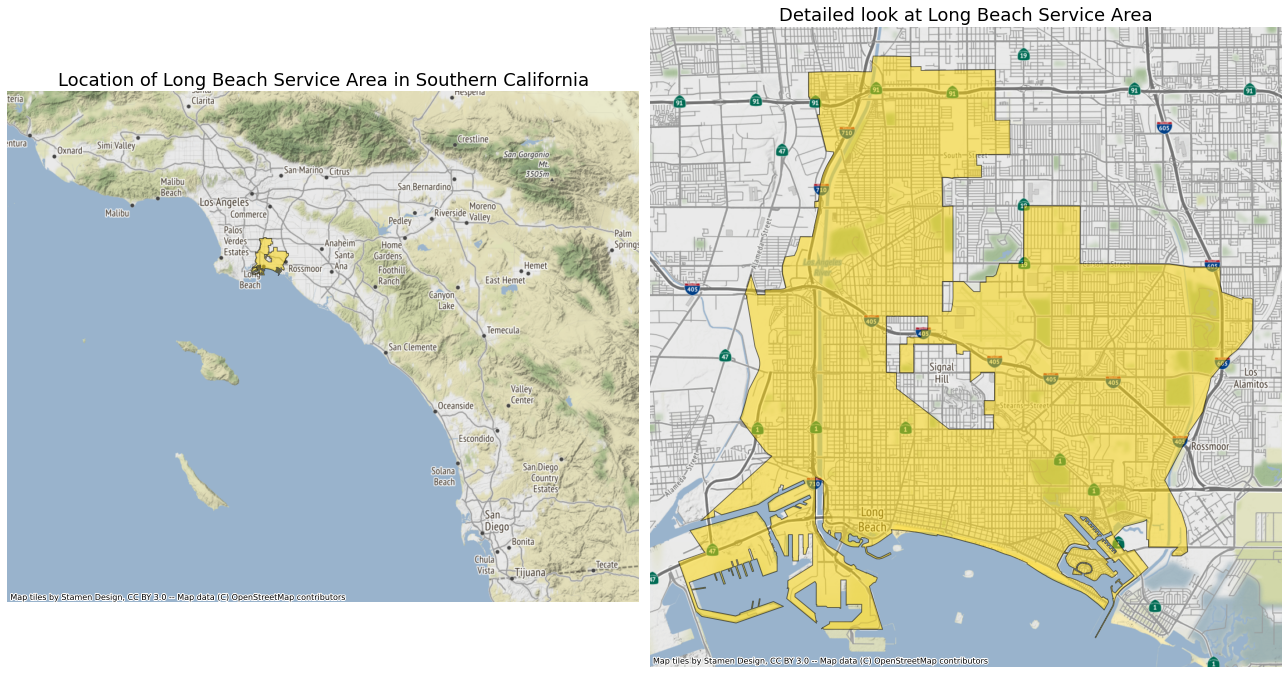

In [4]:
# Check out where Long Beach service area is on a map!
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

servicearea.to_crs('EPSG:3857').plot(color='grey',
                                     alpha=0,
                                     ax=ax1)
lb_servicearea.to_crs('EPSG:3857').plot(color='gold',
                                        alpha=0.5,
                                        linewidth=1,
                                        edgecolor='k',
                                        ax=ax1)
lb_servicearea.to_crs('EPSG:3857').plot(color='gold',
                                        alpha=0.5,
                                        linewidth=1,
                                        edgecolor='k',
                                        ax=ax2)

cx.add_basemap(ax1)
cx.add_basemap(ax2)

ax1.set_axis_off()
ax2.set_axis_off()

ax1.set_title('Location of Long Beach Service Area in Southern California',
              fontsize=18)
ax2.set_title('Detailed look at Long Beach Service Area',
              fontsize=18)

plt.tight_layout()

## NAIP imagery
This approach will use 2020 NAIP data. For the initial workflow development, only 1 NAIP tile will be used. Each individual image covers a 3.75 x 3.75 minute quarter quadrangle plus a 300 meter buffer on all four sides. This is a small subset of the Long Beach service area, as shown below. 

In [5]:
# Open test NAIP file
tile_path = os.path.join('naip',
                         'm_3311816_sw_11_060_20200505',
                         'm_3311816_sw_11_060_20200505.tif')

test_tile = rxr.open_rasterio(tile_path)

# Define bounds of test tile and create polygon of tile footprint
tile_bounds = test_tile.rio.bounds()

lat_point_list = [tile_bounds[1], tile_bounds[1], tile_bounds[3], tile_bounds[3]]
lon_point_list = [tile_bounds[0], tile_bounds[2], tile_bounds[2], tile_bounds[0]]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = test_tile.rio.crs
tile_polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

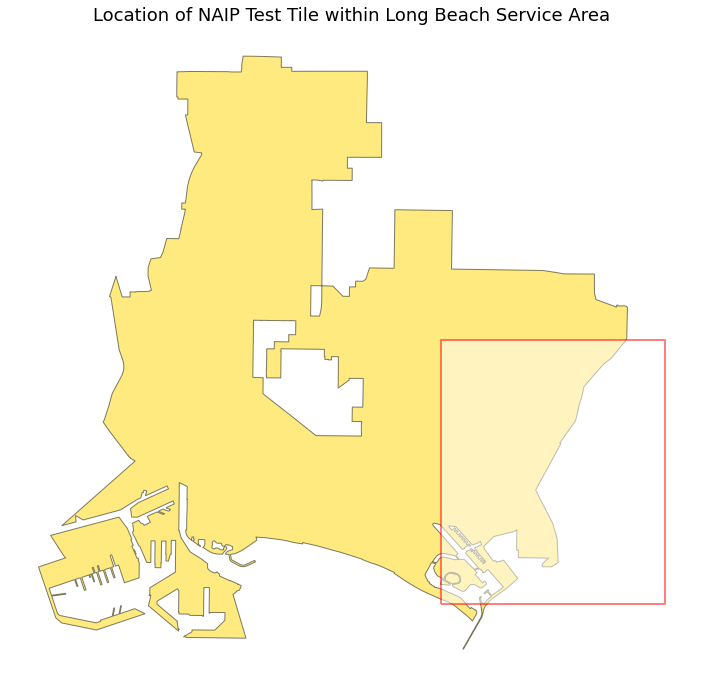

In [7]:
# Plot tile over Long Beach service area boundary
fig, ax = plt.subplots(figsize=(15, 12))

lb_servicearea.to_crs(tile_polygon.crs).plot(color='gold',
                                        alpha=0.5,
                                        linewidth=1,
                                        edgecolor='k',
                                        ax=ax)
tile_polygon.plot(ax=ax,
             color='white',
             edgecolor='r',
             linewidth=2, 
             alpha=.5)
ax.set_title('Location of NAIP Test Tile within Long Beach Service Area', 
             fontsize=18)

ax.set_axis_off()

Notice that the tile doesn't entirely overlap the Long Beach service area. For the purposes of this exercise, we will do the analysis on the entire NAIP test tile so that we have more area to work with. In the future, we can crop the final shapefile of the classified properties to the service area boundary. 

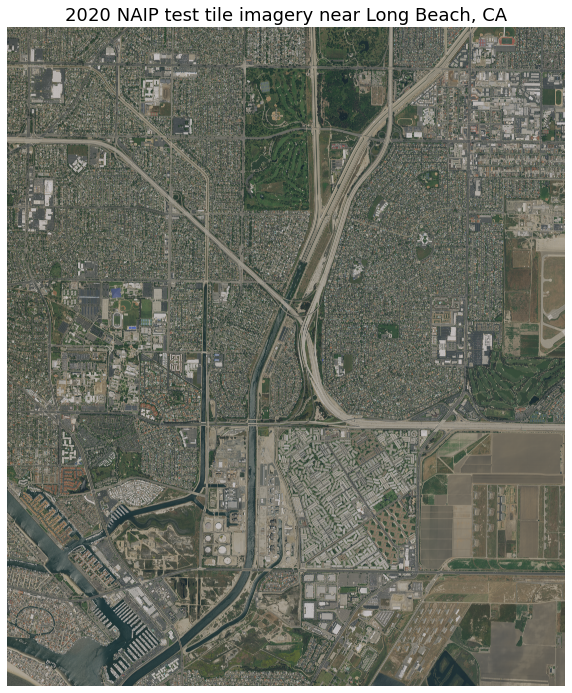

In [8]:
fig, ax = plt.subplots(figsize=(10, 15))

ep.plot_rgb(clean_array_plot(test_tile),
            rgb=[0, 1, 2],
            ax=ax)

ax.set_title('2020 NAIP test tile imagery near Long Beach, CA',
             fontsize=18)

ax.set_axis_off()

Notice above that there are several properties with large landscaped areas. Golf courses, a park, and sports fields are identifiable from this view. These are the landscaped areas we are interested in identifying and calculating their associated areas. 

## Overlaying commercial parcel boundaries

LA County maintains a shapefile of all parcels in the county. This file also contains information about the property, including whether it is a commercial or residential property. We can overlay a shapefile of commercial property boundaries onto our test tile image. 

In [454]:
def get_cii_parcel_polygons(naip_tile):
    """Retrieves non-residential/CII parcel polygons for extent of 
    input NAIP tile using City of Los Angeles : LA County 
    Parcels API.

    Parameters
    ----------
    naip_tile : xarray DataArray
        NAIP tile to use as bounds of API 

    Returns
    -------
    cii_parcel_gdf : GeoDataFrame
        GeoDataFrame of all CII parcel polygons in tile area
    """
    cii_uses = ['Recreational',
                'Commercial',
                'Insitutitonal',
                'Government',
                'Industrial']
    crs_wgs84 = CRS.from_string('EPSG:4326')

    test_tile_reproj = test_tile.rio.reproject(crs_wgs84)
    (xmin, ymin, xmax, ymax) = test_tile_reproj.rio.bounds()

    geom_str = "CENTER_LAT%20%3E%3D%20"+str(ymin)+"%20AND%20CENTER_LAT%20%3C%3D%20"+str(
        ymax)+"%20AND%20CENTER_LON%20%3E%3D%20"+str(xmin)+"%20AND%20CENTER_LON%20%3C%3D%20"+str(xmax)
    
    parcel_gdf_list = []

    for use in cii_uses:
        use_parcel_url = "https://public.gis.lacounty.gov/public/rest/services/LACounty_Cache/LACounty_Parcel/MapServer/0/query?where=" + \
            center_geom_str+"AND%20UseType%3D'"+use + \
            "'&outFields=APN,SitusCity,SitusZIP,UseType,UseDescription,LAT_LON,OBJECTID&outSR=4326&f=json"
        return_dict = json.loads(requests.get(use_parcel_url).text)
        parcel_df = pd.DataFrame(columns=[x["name"] for x in return_dict["fields"]])
        parcel_df.insert(loc=7, column='geometry', value=np.nan)
        parcel_df['geometry'] = parcel_df['geometry'].astype('geometry')

        for i in np.arange(0, len(return_dict['features']), 1):
            att_dict = return_dict['features'][i]['attributes']
            parcel_df = parcel_df.append(att_dict, ignore_index=True)
            geom_dict = return_dict['features'][i]['geometry']
            geom_df = pd.DataFrame(
                data=[str(geom_dict['rings'])], columns=['geometry'])
            poly_data = Polygon(eval(geom_df.geometry.loc[0])[0])
            poly_gdf = gpd.GeoSeries(poly_data)
            parcel_df.loc[i]['geometry'] = poly_gdf[0]

        parcel_gdf = gpd.GeoDataFrame(parcel_df, geometry=parcel_df['geometry'])
        parcel_gdf_list.append(parcel_gdf)
    cii_parcel_gdf = pd.concat(parcel_gdf_list)
    return cii_parcel_gdf

In [455]:
get_cii_parcel_polygons(test_tile)

APN SitusCity SitusZIP       UseType    UseDescription  \
0   7242-030-062                     Recreational  Water Recreation   
1   7242-030-151                     Recreational  Water Recreation   
2   7242-030-153                     Recreational  Water Recreation   
3   7242-030-154                     Recreational  Water Recreation   
4   7242-030-160                     Recreational  Water Recreation   
..           ...       ...      ...           ...               ...   
14  7237-017-014                       Industrial        Industrial   
15  7242-010-900                       Industrial        Industrial   
16  7242-027-902                       Industrial        Industrial   
17  7237-020-029                       Industrial        Industrial   
18  7239-018-015                       Industrial        Industrial   

                   LAT_LON OBJECTID  \
0   33.767035, -118.123932   817261   
1   33.764384, -118.120767   817262   
2   33.764384, -118.120767   817263   
3   33.764384, -118.120767   817264   
4   33.764384, -118.120767   817266   
..                     ...      ...   
14  33.761993, -118.113254  1065807   
15  33.761491, -118.118377  1610441   
16  33.767899, -118.126266  1349839   
17  33.752082, -118.105860  1545344   
18  33.780787, -118.110889   286745   

                                             geometry  
0   POLYGON ((-118.12493 33.76754, -118.12492 33.7...  
1   POLYGON ((-118.12100 33.76550, -118.12107 33.7...  
2   POLYGON ((-118.12100 33.76550, -118.12107 33.7...  
3   POLYGON ((-118.12100 33.76550, -118.12107 33.7...  
4   POLYGON ((-118.12100 33.76550, -118.12107 33.7...  
..                                                ...  
14  POLYGON ((-118.11259 33.75982, -118.11260 33.7...  
15  POLYGON ((-118.11734 33.76168, -118.11745 33.7...  
16  POLYGON ((-118.12607 33.76780, -118.12607 33.7...  
17  POLYGON ((-118.10546 33.75188, -118.10573 33.7...  
18  POLYGON ((-118.10998 33.78056, -118.11013 33.7...  

[713 rows x 8 columns]

In [416]:
# Define CII UseType list
cii_uses = ['Recreational', 
            'Commercial',
            'Insitutitonal', 
            'Government', 
            'Industrial']

In [312]:
# Get geometry of reprojected NAIP tile and build string for api query
crs_wgs84 = CRS.from_string('EPSG:4326')

test_tile_reproj = test_tile.rio.reproject(crs_wgs84)
(xmin, ymin, xmax, ymax) = test_tile_reproj.rio.bounds()

geom_str = "CENTER_LAT%20%3E%3D%20"+str(ymin)+"%20AND%20CENTER_LAT%20%3C%3D%20"+str(
    ymax)+"%20AND%20CENTER_LON%20%3E%3D%20"+str(xmin)+"%20AND%20CENTER_LON%20%3C%3D%20"+str(xmax)

-118.12798869531616

In [432]:
parcel_gdf_list = []

for use in cii_uses:
    use_parcel_url = "https://public.gis.lacounty.gov/public/rest/services/LACounty_Cache/LACounty_Parcel/MapServer/0/query?where=" + \
        center_geom_str+"AND%20UseType%3D'"+use + \
        "'&outFields=APN,SitusCity,SitusZIP,UseType,UseDescription,LAT_LON,OBJECTID&outSR=4326&f=json"
    return_dict = json.loads(requests.get(use_parcel_url).text)
    parcel_df = pd.DataFrame(columns=[x["name"] for x in return_dict["fields"]])
    parcel_df.insert(loc=7, column='geometry', value=np.nan)
    parcel_df['geometry'] = parcel_df['geometry'].astype('geometry')

    for i in np.arange(0, len(return_dict['features']), 1):
        att_dict = return_dict['features'][i]['attributes']
        parcel_df = parcel_df.append(att_dict, ignore_index=True)
        geom_dict = return_dict['features'][i]['geometry']
        geom_df = pd.DataFrame(
            data=[str(geom_dict['rings'])], columns=['geometry'])
        poly_data = Polygon(eval(geom_df.geometry.loc[0])[0])
        poly_gdf = gpd.GeoSeries(poly_data)
        parcel_df.loc[i]['geometry'] = poly_gdf[0]
        
    parcel_gdf = gpd.GeoDataFrame(parcel_df, geometry=parcel_df['geometry'])
    parcel_gdf_list.append(parcel_gdf)

In [436]:
cii_parcel_gdf = pd.concat(parcel_gdf_list)
cii_parcel_gdf

APN      SitusCity    SitusZIP       UseType  \
0   7243-013-002  LONG BEACH CA  90803-5046  Recreational   
1   7242-029-051                             Recreational   
2   7242-029-054                             Recreational   
3   7242-029-058                             Recreational   
4   7242-029-061                             Recreational   
..           ...            ...         ...           ...   
14  7237-020-001                               Industrial   
15  7237-017-011                               Industrial   
16  7237-017-012                               Industrial   
17  7237-022-012                               Industrial   
18  7242-010-900                               Industrial   

                     UseDescription                 LAT_LON OBJECTID  \
0   Athletic & Amusement Facilities  33.756536, -118.122740  1076202   
1                  Water Recreation  33.764623, -118.120295  1077410   
2                  Water Recreation  33.764623, -118.120295  1077411   
3                  Water Recreation  33.764623, -118.120295  1077412   
4                  Water Recreation  33.764623, -118.120295  1077413   
..                              ...                     ...      ...   
14                       Industrial  33.752800, -118.106309  1544656   
15                       Industrial  33.763846, -118.104248  1068175   
16                       Industrial  33.760850, -118.104260  1068176   
17                       Industrial  33.763938, -118.113452  1068177   
18                       Industrial  33.761491, -118.118377  1610441   

                                             geometry  
0   POLYGON ((-118.12268 33.75664, -118.12273 33.7...  
1   POLYGON ((-118.11971 33.76431, -118.11938 33.7...  
2   POLYGON ((-118.11971 33.76431, -118.11938 33.7...  
3   POLYGON ((-118.11971 33.76431, -118.11938 33.7...  
4   POLYGON ((-118.11971 33.76431, -118.11938 33.7...  
..                                                ...  
14  POLYGON ((-118.10626 33.75276, -118.10630 33.7...  
15  POLYGON ((-118.10384 33.76559, -118.10378 33.7...  
16  POLYGON ((-118.10402 33.76154, -118.10402 33.7...  
17  POLYGON ((-118.11257 33.76402, -118.11455 33.7...  
18  POLYGON ((-118.11734 33.76168, -118.11745 33.7...  

[713 rows x 8 columns]

In [430]:
return_dict['features'][999]

{'attributes': {'APN': '5128-014-021',
  'SitusCity': ' ',
  'SitusZIP': ' ',
  'UseType': 'Industrial',
  'UseDescription': 'Parking Lots (Industrial Use Properties)',
  'LAT_LON': '34.018460, -118.264171',
  'OBJECTID': 23169},
 'geometry': {'rings': [[[-118.26414470536304, 34.01854257620695],
    [-118.26400874552351, 34.018521302890086],
    [-118.26405438973062, 34.018449868469865],
    [-118.26412410371549, 34.01834076309298],
    [-118.2642399010754, 34.01839357095314],
    [-118.26435566549526, 34.01844635129617],
    [-118.26428424434127, 34.018558180932196],
    [-118.26414470536304, 34.01854257620695]]]}}

In [425]:
parcel_url = "https://public.gis.lacounty.gov/public/rest/services/LACounty_Cache/LACounty_Parcel/MapServer/0/query?where=UseType%20%3D%20'Commercial'&outFields=APN,SitusCity,SitusZIP,UseType,UseDescription,LAT_LON,OBJECTID&outSR=4326&f=json"

In [426]:
d = json.loads(requests.get(parcel_url).text)
list(d.keys())

['displayFieldName',
 'fieldAliases',
 'geometryType',
 'spatialReference',
 'fields',
 'features',
 'exceededTransferLimit']

In [252]:
parcel_df = pd.DataFrame(columns=[x["name"] for x in d["fields"]])
parcel_df.insert(loc=7, column='geometry', value=np.nan)
parcel_df['geometry'] = parcel_df['geometry'].astype('geometry')

feature_i = np.arange(0, len(d['features']), 1) 

for i in feature_i:
    att_dict = d['features'][i]['attributes']
    parcel_df = parcel_df.append(att_dict, ignore_index=True)
    geom_dict = d['features'][i]['geometry']
    geom_df = pd.DataFrame(data = [str(geom_dict['rings'])], columns=['geometry'])
    poly_data = Polygon(eval(geom_df.geometry.loc[0])[0])
    poly_gdf = gpd.GeoSeries(poly_data)
    parcel_df.loc[i]['geometry'] = poly_gdf[0]

In [414]:
parcel_gdf = gpd.GeoDataFrame(
    parcel_df, geometry=parcel_df['geometry'])
parcel_gdf.head(1)

APN    SitusCity    SitusZIP     UseType UseDescription  \
0  7524-015-022  TORRANCE CA  90503-4614  Commercial         Stores   

                  LAT_LON OBJECTID  \
0  33.839286, -118.353174       30   

                                            geometry  
0  POLYGON ((-118.35350 33.83936, -118.35350 33.8...

In [355]:
geom_envel_str = str(xmin)+','+str(ymin)+','+str(xmax)+','+str(ymax)
geom_str = "geometryType=esriGeometryPolygon&geometry={xmin:"+str(xmin)+",ymin:"+str(ymin)+",xmax:"+str(xmax)+",ymax:"+str(ymax)+"}"
center_geom_str = "CENTER_LAT%20%3E%3D%20"+str(ymin)+"%20AND%20CENTER_LAT%20%3C%3D%20"+str(ymax)+"%20AND%20CENTER_LON%20%3E%3D%20"+str(xmin)+"%20AND%20CENTER_LON%20%3C%3D%20"+str(xmax)

In [410]:
parcel_url_with_env = "https://public.gis.lacounty.gov/public/rest/services/LACounty_Cache/LACounty_Parcel/MapServer/0/query?where=geometryType=esriGeometryEnvelope&geometry="+geom_str+"&inSR={'wkid':%204246&outFields=APN,SitusCity,SitusZIP,UseType,UseDescription,LAT_LON,OBJECTID&outSR=4326&f=json"

parcel_url_with_bounds = "https://public.gis.lacounty.gov/public/rest/services/LACounty_Cache/LACounty_Parcel/MapServer/0/query?where="+center_geom_str+"AND%20UseType%3D'COMMERCIAL'&outFields=APN,SitusCity,SitusZIP,UseType,UseDescription,LAT_LON,OBJECTID&outSR=4326&f=json"

In [411]:
dgeo = json.loads(requests.get(parcel_url_with_bounds).text)
list(dgeo.keys())

['displayFieldName',
 'fieldAliases',
 'geometryType',
 'spatialReference',
 'fields',
 'features']

In [412]:
len(dgeo['features'])

224

In [ ]:
# Function to pull LA County CII parcel data based on input: naip tile (gets bounds to use as geometry in api query)
# Returns geodataframe of 

In [9]:
# Open test parcel shapefile (sample area downloaded into ArcGIS and saved)
parcels_path = os.path.join('parcels',
                            'Parcels.shp')

la_parcels = gpd.read_file(parcels_path)

la_parcels_reproj = la_parcels.to_crs(tile_polygon.crs)

# clipped_parcels = gpd.clip(la_parcels_reproj, tile_polygon)

Text(0.5, 1.0, 'Parcel boundaries in test tile area (and beyond)')

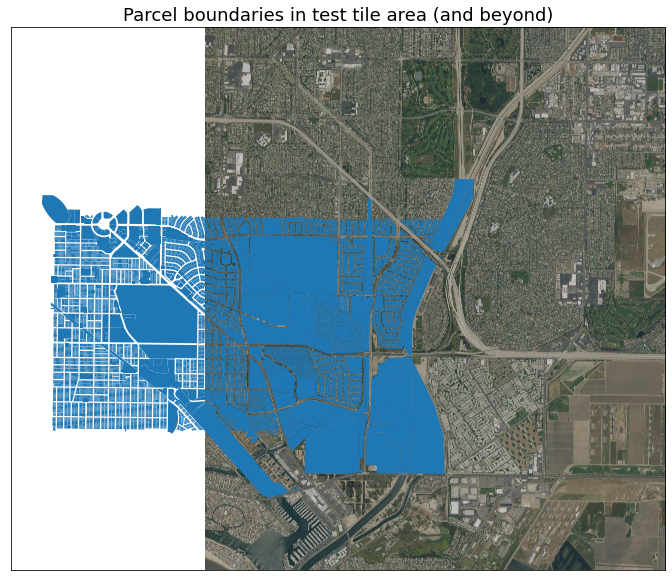

In [10]:
tile_extent = plotting_extent(test_tile[0],
                              test_tile.rio.transform())

fig, ax = plt.subplots(figsize=(12,10))

ep.plot_rgb(clean_array_plot(test_tile),
            rgb=[0, 1, 2],
            ax=ax, 
            extent=tile_extent)

la_parcels_reproj.plot(ax=ax)

ax.set_title('Parcel boundaries in test tile area (and beyond)', 
             fontsize=18)

I finally got the crazy LA County ArcGIS portal to spit out some parcel data, but it seems to have only exported those within the extent of the Online Map Viewer. I then had to open the layer in ArcGIS Pro desktop, then export it as a shapefile to import here. I'll work on this more.

In [11]:
# Subset to just commercial, industrial, institutional (non-residential) parcels
cii_parcels = la_parcels_reproj[(la_parcels_reproj['UseType'] == 'Recreational') |
                                (la_parcels_reproj['UseType'] == 'Commercial') |
                                (la_parcels_reproj['UseType'] == 'Institutional') |
                                (la_parcels_reproj['UseType'] == 'Industrial') |
                                (la_parcels_reproj['UseType'] == 'Government')]

In [394]:
cii_parcels['UseType'].unique()

array(['Recreational', 'Commercial', 'Institutional', 'Industrial',
       'Government'], dtype=object)

Text(0.5, 1.0, 'Commercial, Instititutional, Industrial, Recreational and Government parcels')

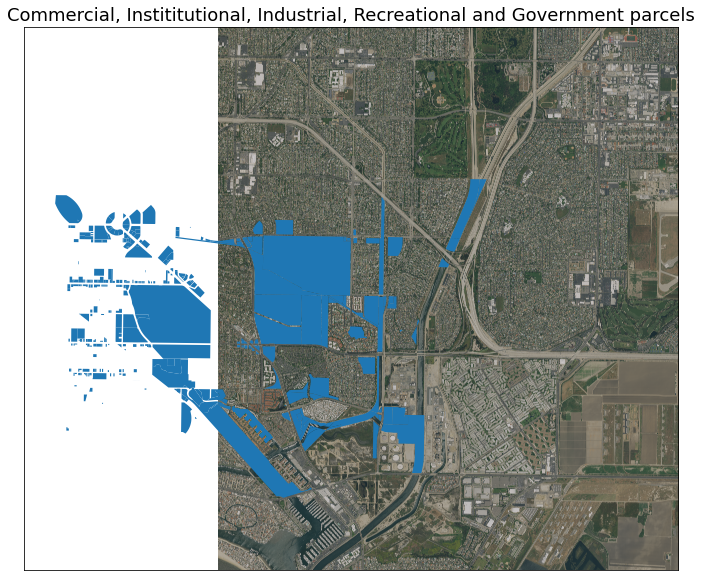

In [12]:
fig, ax = plt.subplots(figsize=(12,10))

ep.plot_rgb(clean_array_plot(test_tile),
            rgb=[0, 1, 2],
            ax=ax, 
            extent=tile_extent)

cii_parcels.plot(ax=ax)


ax.set_title('Commercial, Instititutional, Industrial, Recreational and Government parcels', 
             fontsize=18)

This cii_parcel shapefile will eventually be used to calculate the landscaped area once the NAIP imagery is classified. 

## Land cover classification overview
For the land cover classification, I will use the [RandomForest (Brieman 2001)](https://link.springer.com/article/10.1023/A:1010933404324) ensemble decision tree algorithm by Leo Breiman and Adele Cutler, outlined in the [random-forest-classification tutorial](https://ipynb.pub/view/56d44f62d08fcf329af9077a9e274c21b8a281e09e4ef0695392a0da860977eb#displayOptions=). RandomForest utilizes the scikit-learn Python library. 

This is a supervised classification approach which inputs training polygons. The training polygons were manually created in ArcGIS Pro using the NAIP test tile as guidance, and assigned a classification of either 1-Turf or 2-Shrubs/Trees. 

In [13]:
# Open training polygons
training_path = os.path.join('training', 
                             'training_polys1.shp')

training_polys = gpd.read_file(training_path)

training_polys_reproj = training_polys.to_crs(tile_polygon.crs)

Text(0.5, 1.0, 'Training polygons over NAIP test tile\nGreen = Turf, Orange = Shrubs/Trees')

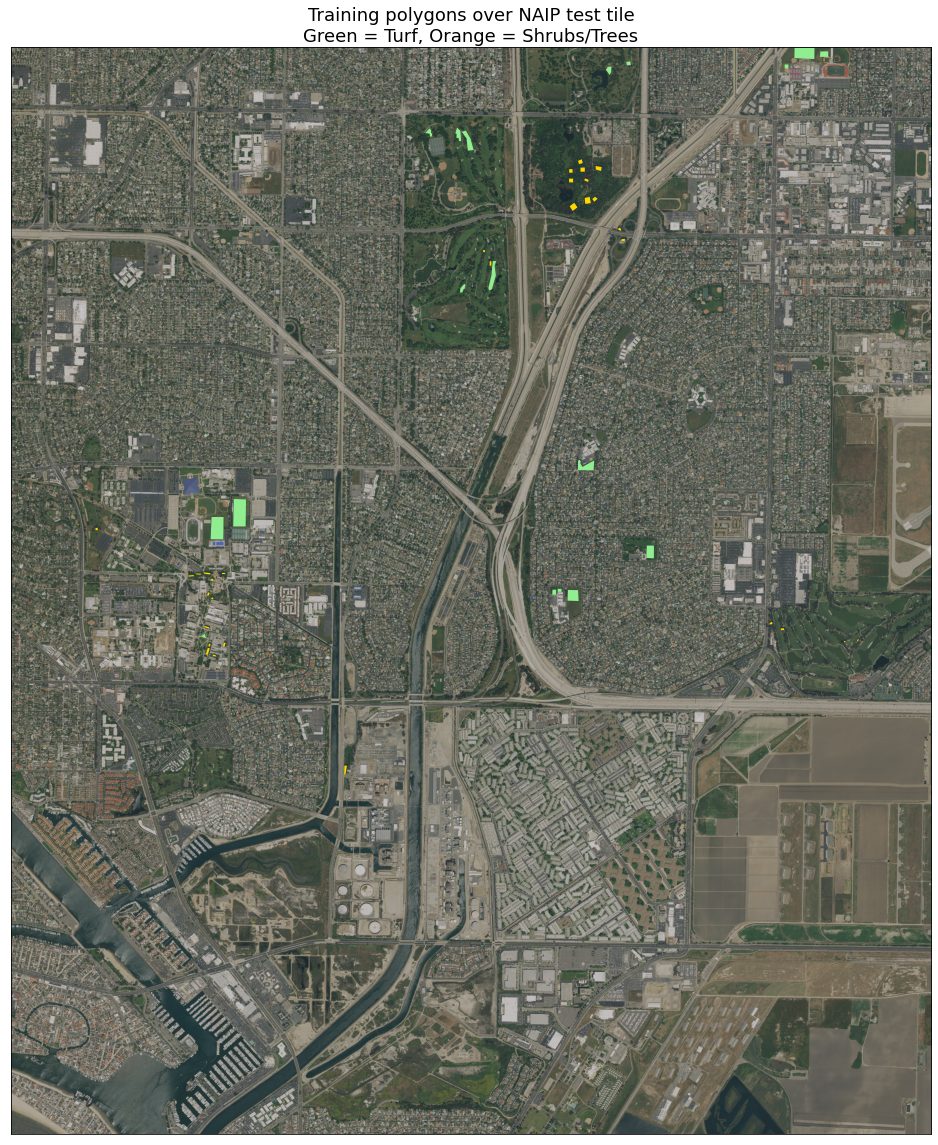

In [14]:
# Plot training polygons on NAIP test tile
colors = {'Turf': 'lightgreen',
          'Trees/Shrubs': 'gold'}

fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_rgb(clean_array_plot(test_tile),
            rgb=[0, 1, 2],
            ax=ax, 
            extent=tile_extent)

for cover_type, df in training_polys_reproj.groupby('DESCRIPTIO'):
    color = colors[cover_type]
    df.plot(color=color,
            ax=ax,
            label=cover_type)

ax.set_title('Training polygons over NAIP test tile\nGreen = Turf, Orange = Shrubs/Trees', 
             fontsize=18)

Text(0.5, 1.0, 'Training polygons over NAIP test tile\nGreen = Turf, Orange = Shrubs/Trees')

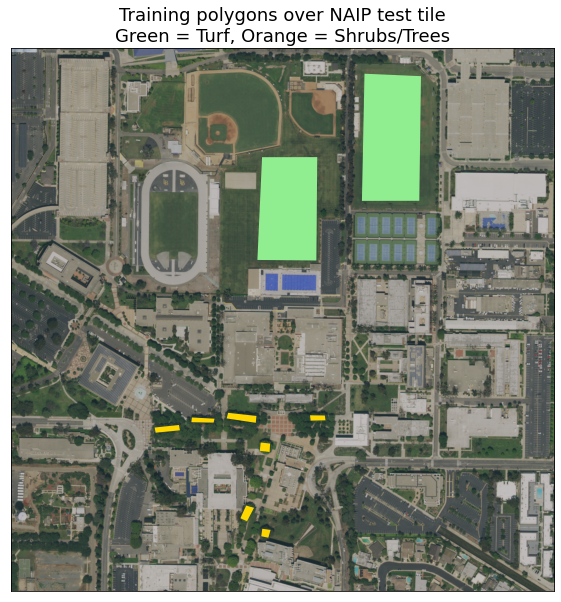

In [15]:
# Zoom in to see details of training polygons
colors = {'Turf': 'lightgreen',
          'Trees/Shrubs': 'gold'}

fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_rgb(clean_array_plot(test_tile),
            rgb=[0, 1, 2],
            ax=ax, 
            extent=tile_extent)

for cover_type, df in training_polys_reproj.groupby('DESCRIPTIO'):
    color = colors[cover_type]
    df.plot(color=color,
            ax=ax,
            label=cover_type)

ax.set_xlim([396600, 397400])
ax.set_ylim([3738300, 3739100])

ax.set_title('Training polygons over NAIP test tile\nGreen = Turf, Orange = Shrubs/Trees', 
             fontsize=18)

## Next steps
The training polygons can now be incorporated into the RandomForest workflow. Next steps include: 
* Get appropriate extent of parcel data 
* Work through RandomForest landcover classification tutorial 
* Calculate landscaped area and summarize across test tile
* Scale up to perform all above tests at service area level